In [2]:
import sys
sys.path.insert(0, "..")
import face_alignment.api as face_alignment
import numpy as np
import torch
import PIL.Image as Image
import cv2
import pickle as pkl
from tqdm import tqdm

from matplotlib import pyplot as plt

In [3]:
fa_model = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D)

In [4]:
from PIL import Image, ExifTags

def rotate_image_with_exif(image_pil):
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation]=='Orientation':
                break

        exif = image_pil._getexif()

        if exif[orientation] == 3:
            image_pil=image_pil.rotate(180, expand=True)
        elif exif[orientation] == 6:
            image_pil=image_pil.rotate(270, expand=True)
        elif exif[orientation] == 8:
            image_pil=image_pil.rotate(90, expand=True)
        return image_pil
    except (AttributeError, KeyError, IndexError):
        # cases: image don't have getexif
        return image_pil

In [5]:
def resize_image(image_pil, target_size=720):
    w, h = image_pil.size
    ratio = h / float(w)
    if ratio > 1:  # h > w
        scale = w / float(target_size)
        to_w = target_size
        to_h = int(target_size * ratio)
    else:
        scale = h / float(target_size)
        to_h = target_size
        to_w = int(target_size / ratio)
    
    image_pil_new = image_pil.resize((to_w, to_h), Image.BICUBIC)
    return np.array(image_pil_new), scale

In [6]:
def rm_landmarks(landmark, rm_list):
    landmark = landmark.tolist()
    for i in sorted(rm_list, reverse=True):
        del landmark[i]

    return landmark

def get_landmarks(image, fa_model=None):
    rm_landmark_list = [1, 2, 4, 5, 7, 15, 14, 12, 11, 9, 49, 51, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 19, 25, 28, 29, 33, 40, 47]

    with torch.no_grad():
        image_resized, scale = resize_image(image)
        landmark = fa_model.get_landmarks(image_resized)
    landmark_final = rm_landmarks(landmark[0], rm_landmark_list)
    landmark = np.array(landmark_final)
    # landmark *= scale

    return image_resized, landmark

In [7]:

from skimage.transform import PiecewiseAffineTransform, warp
from numpy.random import normal, uniform    

def warp_face(image, distribution='Uniform', warp_scale=3, warp_min=0.2, fa_model=None):
    assert distribution in ['Normal', 'Uniform']
    assert warp_scale > 0

    image_resized, landmarks = get_landmarks(image, fa_model)

    image_ = image_resized.copy()
    landmarks_ls = landmarks.tolist()
    for landmark in landmarks_ls:
        cv2.circle(image_, (int(landmark[0]), int(landmark[1])), 3, (255, 255, 255), 3)
    plt.imshow(image_)
    plt.show()  

    if distribution == 'Normal':
        noisy_landmarks = landmarks.copy() + np.random.normal(0, warp_scale, landmarks.shape) + warp_min
    elif distribution == 'Uniform':
        noisy_landmarks = landmarks.copy() + np.random.uniform(-warp_scale - warp_min, warp_scale, landmarks.shape) + warp_min

    image_corners = np.array([[0,0], [image_resized.shape[1], 0], [0, image_resized.shape[0]], [image_resized.shape[1], image_resized.shape[0]]])

    transform_points = np.append(landmarks, image_corners, axis=0)
    noisy_transform_points = np.append(noisy_landmarks, image_corners, axis=0)

    transform = PiecewiseAffineTransform()
    transform.estimate(noisy_transform_points, transform_points)

    warped = warp(image_resized, transform, output_shape=image_resized.shape)
    

    return image_resized, warped

/workspace/bioposh_classification/examples


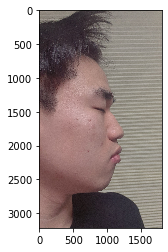

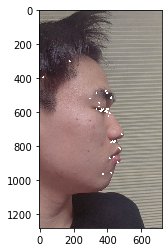

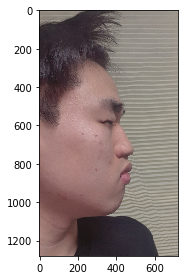

In [8]:
import os
print(os.getcwd())
image_path = '/workspace/right/10.jpg'
image = Image.open(image_path)
image = rotate_image_with_exif(image)
plt.imshow(image, interpolation='nearest')
plt.show()

resized_image, warped_image = warp_face(image=image, distribution='Uniform', warp_scale=10, fa_model=fa_model)

plt.imshow(warped_image, interpolation='nearest', resample=False)
plt.tight_layout()
plt.show()

# im = Image.fromarray(resized_image)
# im.save('normal.jpg')
# im2 = Image.fromarray((warped_image * 255).astype(np.uint8))
# im2.save('warped.jpg')




In [9]:
import pickle

image_path = '/workspace/front/10.pkl'

with open(image_path,'rb') as f:
    data = pickle.load(f)
    
print(data)

{'landmark': array([[ 346, 1491],
       [ 346, 1674],
       [ 386, 1835],
       [ 406, 1976],
       [ 467, 2136],
       [ 547, 2277],
       [ 647, 2357],
       [ 750, 2418],
       [ 951, 2458],
       [1152, 2418],
       [1273, 2317],
       [1373, 2237],
       [1453, 2096],
       [1514, 1915],
       [1534, 1775],
       [1554, 1612],
       [1574, 1431],
       [ 426, 1310],
       [ 487, 1250],
       [ 587, 1210],
       [ 670, 1230],
       [ 750, 1230],
       [1092, 1230],
       [1172, 1190],
       [1253, 1190],
       [1353, 1210],
       [1413, 1270],
       [ 931, 1471],
       [ 931, 1592],
       [ 931, 1695],
       [ 931, 1775],
       [ 831, 1855],
       [ 871, 1855],
       [ 931, 1875],
       [ 991, 1855],
       [1052, 1855],
       [ 567, 1471],
       [ 627, 1471],
       [ 690, 1451],
       [ 770, 1471],
       [ 690, 1491],
       [ 627, 1491],
       [1112, 1451],
       [1172, 1431],
       [1253, 1431],
       [1313, 1431],
       [1253, 1471],
